In [1]:
# Short term prediction of Bitcoin market price using XGBoost

# XGBoost
> XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. In prediction problems involving unstructured data (images, text, etc.) artificial neural networks tend to outperform all other algorithms or frameworks. However, when it comes to small-to-medium structured/tabular data, decision tree based algorithms are considered best-in-class right now. Please see the chart below for the evolution of tree-based algorithms over the years.

> XGBoost algorithm was developed as a research project at the University of Washington. Tianqi Chen and Carlos Guestrin presented their paper at SIGKDD Conference in 2016 and caught the Machine Learning world by fire. Since its introduction, this algorithm has not only been credited with winning numerous Kaggle competitions but also for being the driving force under the hood for several cutting-edge industry applications. As a result, there is a strong community of data scientists contributing to the XGBoost open source projects with ~350 contributors and ~3,600 commits on GitHub


# Importing Library 📚

In [2]:
# Here we are importing Library which are required 
import pandas as pd
import numpy as np
import math
import datetime as dt

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Loading Dataset 📚

### About Data
> 1. Date - Date.
> 2. Open - It is the price at which the financial security opens in the market when trading begins.
> 3. High - The high is the highest price at which a Bitcoin traded during a period.
> 4. Low - Low is the minimum price of a Bitcoin in a period.
> 5. Close - Closing price generally refers to the last price at which a Bitcoin trades during a regular trading session.
> 6. Adj Close - The adjusted closing price amends a Bitcoin's closing price to reflect that Bitcoin's value after accounting for any
> 7. Volume - Volume measures the number of shares traded in a Bitcoin or contracts traded in futures or options. 

In [3]:
# Loading Dataset and remainig its columns

data=pd.read_csv('BTC-USD.csv')
data = data.rename(columns={'Date': 'date','Open':'open','High':'high','Low':'low','Close':'close',
                                'Adj Close':'adj_close','Volume':'volume'})

In [4]:
# Displaying first 5 rows of the dataset

data.head()

,date,open,high,low,close,adj_close,volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


In [5]:
# Displaying Last 5 rows of the dataset

data.tail()

,date,open,high,low,close,adj_close,volume
1157,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094,63167.371094,26253811450
1158,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063,68330.414063,70670471105
1159,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219,63801.199219,102802940877
1160,2024-03-06,63776.050781,67637.929688,62848.671875,66106.804688,66106.804688,68750229073
1161,2024-03-07,66099.742188,68029.921875,65655.531250,66925.484375,66925.484375,46989543159


In [6]:
data.shape

(1162, 7)

In [7]:
# describe() is used to view some basic statistical details like percentile, mean, std etc. of a data frame or a series of numeric values

data.describe()

,open,high,low,close,adj_close,volume
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1.162000e+03
mean,35573.425444,36386.347271,34703.206732,35602.451668,35602.451668,3.172501e+10
std,12682.061348,13056.430864,12272.933957,12709.049647,12709.049647,2.036392e+10
min,15782.300781,16253.047852,15599.046875,15787.284180,15787.284180,5.331173e+09
25%,25903.562500,26199.793457,25594.541504,25903.288574,25903.288574,1.865285e+10
50%,34239.847657,35037.259765,33028.099610,34237.691407,34237.691407,2.761572e+10
75%,44158.390625,45079.763672,43239.455078,44165.624024,44165.624024,3.858013e+10
max,68341.054688,69170.625000,66382.062500,68330.414063,68330.414063,3.509679e+11


# Checking for null values

In [8]:
data.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

Convert date field from string to Date format 

In [9]:
data['date'] = pd.to_datetime(data.date)
data.head()

,date,open,high,low,close,adj_close,volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782


Finding the duration of dataset

In [10]:
print("Starting date: ",data.iloc[0])
print("Ending date: ", data.iloc[-1])
print("Duration: ", data.iloc[-1]-data.iloc[0])

Starting date:  date         2021-01-01 00:00:00
open                28994.009766
high                29600.626953
low                 28803.585938
close               29374.152344
adj_close           29374.152344
volume               40730301359
Name: 0, dtype: object
Ending date:  date         2024-03-07 00:00:00
open                66099.742188
high                68029.921875
low                  65655.53125
close               66925.484375
adj_close           66925.484375
volume               46989543159
Name: 1161, dtype: object
Duration:  date         1161 days 00:00:00
open               37105.732422
high               38429.294922
low                36851.945312
close              37551.332031
adj_close          37551.332031
volume               6259241800
dtype: object


# EDA  📊 📈 📉
- EDA in Python uses data visualization to draw meaningful patterns and insights. It also involves the preparation of data sets for analysis by removing irregularities in the data. Based on the results of EDA, companies also make business decisions, which can have repercussions later

### Overall Analysis from 2021 - 2024

In [11]:
y_overall=data
y_overall.drop(y_overall[['adj_close','volume']],axis=1)

,date,open,high,low,close
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688
...,...,...,...,...,...
1157,2024-03-03,62031.578125,63230.210938,61435.023438,63167.371094
1158,2024-03-04,63137.003906,68537.031250,62386.519531,68330.414063
1159,2024-03-05,68341.054688,69170.625000,59323.910156,63801.199219
1160,2024-03-06,63776.050781,67637.929688,62848.671875,66106.804688


In [12]:
monthwise= y_overall.groupby(y_overall['date'].dt.strftime('%B'))[['open','close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)

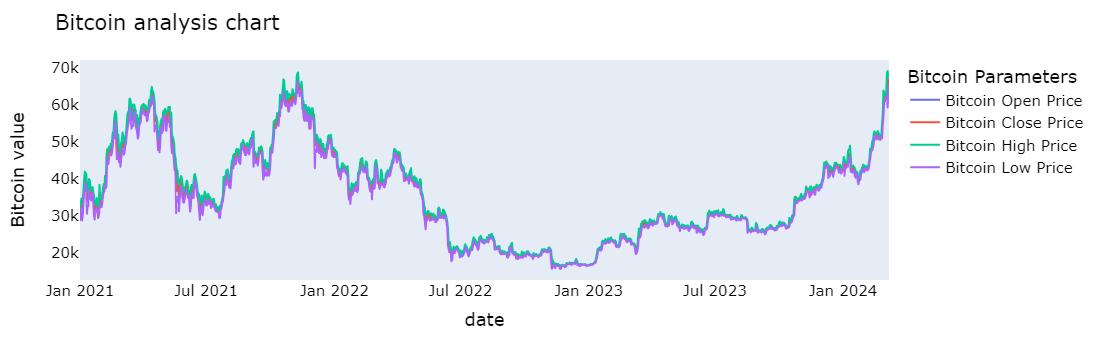

In [13]:
names = cycle(['Bitcoin Open Price','Bitcoin Close Price','Bitcoin High Price','Bitcoin Low Price'])

fig = px.line(y_overall, x=y_overall.date, y=[y_overall['open'], y_overall['close'], 
                                          y_overall['high'], y_overall['low']],
             labels={'Date': 'Date','value':'Bitcoin value'})
fig.update_layout(title_text='Bitcoin analysis chart', font_size=15, font_color='black',legend_title_text='Bitcoin Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

### Creating new dataframe of Bitcoin data containing only date and closing price

In [14]:
closedf = data[['date','close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (1162, 2)


In [15]:
closedf = closedf[closedf['date'] > '2023-03-07']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  366


### Normalizing close price value

In [16]:
del closedf['date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(366, 1)


# Separate data for Train and Test 🎬

In [17]:
training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (292, 1)
test_data:  (74, 1)


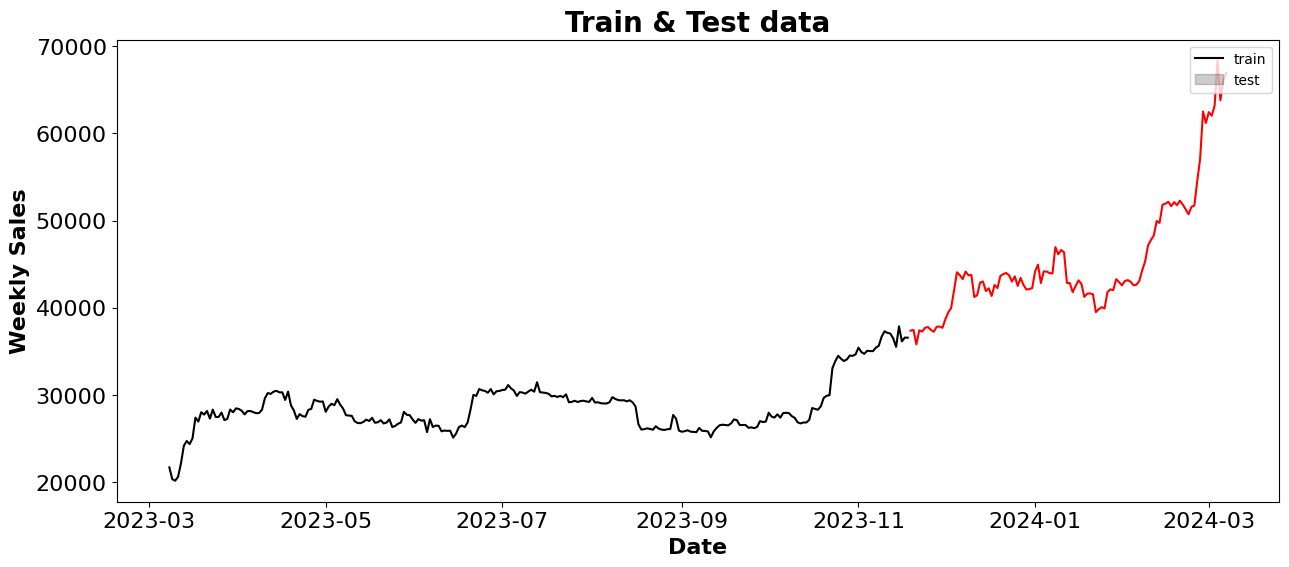

In [18]:
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x = close_stock['date'][:256], y = close_stock['close'][:256], color = 'black')
sns.lineplot(x = close_stock['date'][256:], y = close_stock['close'][256:], color = 'red')

# Formatting
ax.set_title('Train & Test data', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('Weekly Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.legend(loc='upper right' ,labels = ('train', 'test'))
plt.show()

# Prepare train data for time series analysis

In [19]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (276, 15)
y_train:  (276,)
X_test:  (58, 15)
y_test (58,)


# Import XGBRegressor module and Fit X_train and y_train for training model

In [21]:
# Biulding Model

my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.1425138908195149
Root Mean squared Error - RMSE : 0.20848742044226154


In [23]:
train_predict=my_model.predict(X_train)
test_predict=my_model.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (276, 1)
Test data prediction: (58, 1)


In [24]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

Train predicted data:  (366, 1)
Test predicted data:  (366, 1)


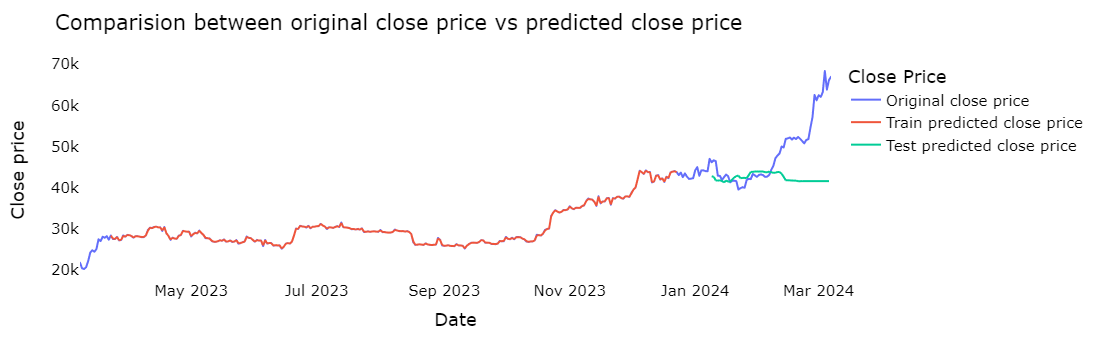

In [25]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])

plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Close price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Prediction next 30 days

In [26]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        
        yhat = my_model.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        yhat = my_model.predict(x_input)
        
        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())
        
        i=i+1
        
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [27]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


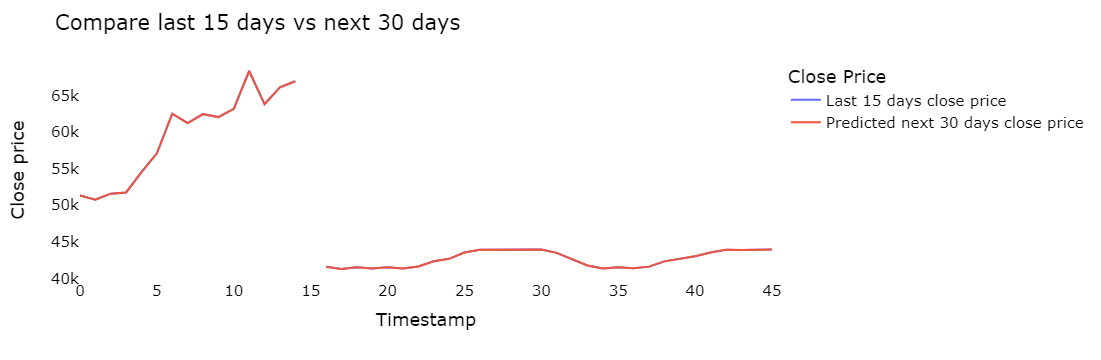

In [28]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

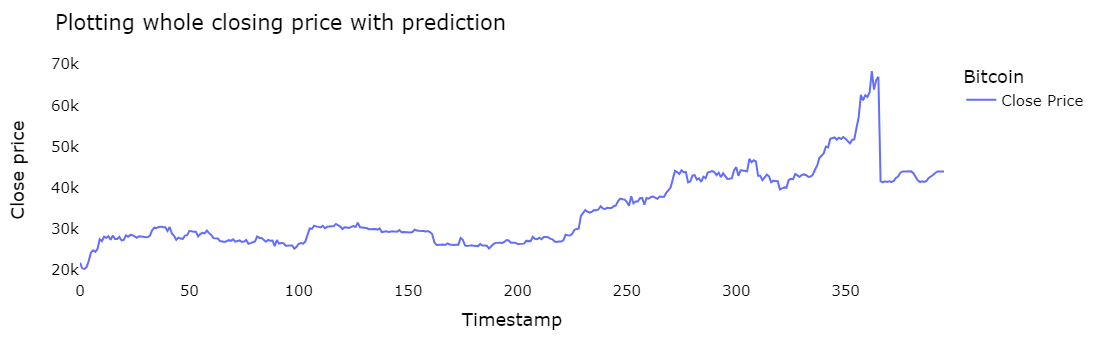

In [29]:
my_model=closedf.tolist()
my_model.extend((np.array(lst_output).reshape(-1,1)).tolist())
my_model=scaler.inverse_transform(my_model).reshape(1,-1).tolist()[0]

names = cycle(['Close Price'])

fig = px.line(my_model,labels={'value': 'Close price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Bitcoin')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()